# Notebook : Parallel Median Filter with Dask

In [1]:
# Importing Libraries
import numpy as np
from dask_image import imread
from dask.array import overlap
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

## I. Loading Input Image  

dask.array<_map_read_frame, shape=(1, 128, 128, 3), dtype=uint8, chunksize=(1, 128, 128, 3), chunktype=numpy.ndarray>

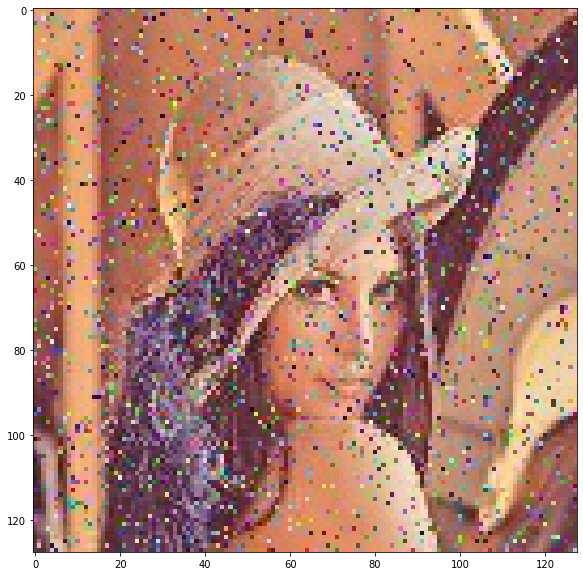

In [2]:
file = "lena_noisy.jpg"
noisy = imread.imread(file)
plt.imshow(noisy[0])
noisy

The manipulated image is clearly too small sized to be spread among different Dask chunks, thus, in order to run the parallelization demo, we need to **explicitly divide it into many chunks**.  
Splitting an RGB image *(3 dimensions)* can be done in many ways, the most intuitive one is to **split into RGB sub-images with a given height and width** *(the image resolution doesn't have to be a multiple of the sub-dimensions since Dask handles unbalanced tasks)*. This partition is the most suitable given the **2D convolutional nature** of the operation to be performed *(9-sized median)*. 

## II. Dividing the image into Chunks  
### II.1 Naive partition

In [3]:
blockDimX = 8
blockDimY = 8
blockDimZ = 3

In [4]:
chunkedImage = noisy[0].rechunk(chunks=(blockDimX, blockDimY, blockDimZ))
chunkedImage

,Array,Chunk
Bytes,49.15 kB,192 B
Shape,"(128, 128, 3)","(8, 8, 3)"
Count,515 Tasks,256 Chunks
Type,uint8,numpy.ndarray


The problem with this basic parition has to do with the nature of the median operation : for each pixel (i,j), all the 8 surrounding pixels need to be known in order to compute the median. This will create a problem in the borders of each chunk, since theirs pixels have access to no more than 5 pixels, the others being in a neighbouring chunk. 
Thus, for the computations to be processed correctly, each chunk has to work on *(blockDimX+2 * blockDimY+2 * 3)* pixels, the 4 additional borders playing the role of a **'Data Halo'** also called **'Ghost Points'**.  
Such situations can be handled through Dask's overlapping routines : **overlap** and **map_overlap**.

## II.2 Overlapped Chunks  
Besides the internal chunks that need to include halo points from neighborhood, the original image's extreme borders also need to be handled using a padding method. We chose a reflection based padding, which results in more realistic values since we're dealing with images. 

In [5]:
chunkedOverlappedImage = overlap.overlap(chunkedImage, depth={0: 1, 1: 1}, boundary={0: 'reflect', 1: 'reflect'})

In [6]:
chunkedOverlappedImage.chunks

((10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10),
 (10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10),
 (3,))

In [7]:
chunkedOverlappedImage

,Array,Chunk
Bytes,76.80 kB,300 B
Shape,"(160, 160, 3)","(10, 10, 3)"
Count,4479 Tasks,256 Chunks
Type,uint8,numpy.ndarray


We can see that the new chunks' dimensions are *(blockDimX+2, blockDimY+2, 3)*, which results in a larger image due to the redundant halo pixels.  
The following juxtaposed chunk subsets illustrate the **reflection padding** *(first chunk in the upper and left pixels)*, and the 1-depth **overlapping** effect along the y axis *(second chunk in the left most pixels)*.  

In [8]:
# CHUNK 1
np.array(chunkedOverlappedImage)[0:10,0:10,0]

array([[237, 237, 230, 229, 230, 234, 234, 226, 220, 217],
       [237, 237, 230, 229, 230, 234, 234, 226, 220, 217],
       [224, 224, 226, 228, 200,  60, 193, 204, 219, 229],
       [208, 208, 207, 251, 143, 166, 162, 180, 208, 231],
       [128, 128, 197, 203, 203, 183, 179, 182, 164, 210],
       [173, 173, 197, 225, 179, 224, 219, 200, 172,  73],
       [194, 194, 211, 227, 232, 223, 227, 226, 209, 205],
       [215, 215, 225, 228, 215, 139, 210, 227, 230, 230],
       [230, 230, 238, 255, 219, 202, 199, 219, 234, 241],
       [233, 233, 230, 237, 234, 224, 223, 221, 226, 234]], dtype=uint8)

In [9]:
# CHUNK 2
np.array(chunkedOverlappedImage)[0:10,10:20,0]

array([[220, 217, 226, 249, 243, 224, 222, 224, 202, 148],
       [220, 217, 226, 249, 243, 224, 222, 224, 202, 148],
       [219, 229, 241, 240, 244, 236, 230, 217, 182, 163],
       [208, 231, 234, 238, 238, 245, 238, 205, 117, 166],
       [164, 210, 152, 229, 232, 220, 212, 157, 172, 174],
       [172,  73, 203, 229, 231, 200, 190, 199, 196, 166],
       [209, 205, 214, 239, 235, 210, 175, 195, 160, 160],
       [230, 230, 228, 243, 241, 222, 210, 205, 190, 166],
       [234, 241, 230, 230, 230, 232, 233, 209, 176, 170],
       [226, 234, 221, 159, 199, 230, 246, 213, 171, 173]], dtype=uint8)

## III. Overlapped mapping of the parallel Medial Filter  
### III.1 Partial Median Filter  
We implement a partial median filter that takes the extended chunks as input and returns the median values for the original chunk dimensions.

In [10]:
def partialMedianFun(array, xStart, xEnd, yStart, yEnd, chunkShape):
    chunkResult = np.ndarray(chunkShape, dtype=np.uint8)
    for i in range(1,xEnd-xStart-1):
        
        for j in range(1, yEnd-yStart-1):
            selectedPixels = array[ i-1: i+2,j-1:j+2,:]
            median = [int(val) for val in np.median(selectedPixels, axis=(0,1))]
            chunkResult[i, j, :] = median
            
    return(chunkResult)

The block_info arg helps passing chunk related meta-data *(Array location, Chunk Shape etc..)* to the sub-routine to control loop operations and data accesses.

In [11]:
def partial_median(block, block_info=None):
    if not block_info is None :
        (xStart, xEnd) = block_info[None]['array-location'][0]
        (yStart, yEnd) = block_info[None]['array-location'][1]
        chunkShape = block_info[None]['chunk-shape']          
        
        return(partialMedianFun(block, xStart, xEnd, yStart, yEnd, chunkShape))
        
    return partialMedianFun(block, 0, 0, 0, 0, (8,8,3))

### III.2 Median Filter Overlapped Mapping  
The overlapped mapping is insured directly through the map_overlap method to which we pass the halo size along the considered dimensions *(depth)* and the boundary padding method *(boundary)*. Trimming the result is mandatory to get rid of the halo pixels.

In [13]:
filteredG = chunkedImage.map_overlap(partial_median, depth={0:1,1:1,2:0}, 
                                boundary={0: 'reflect', 1: 'reflect'},
                                trim=True)

In [14]:
filteredG

,Array,Chunk
Bytes,49.15 kB,192 B
Shape,"(128, 128, 3)","(8, 8, 3)"
Count,5503 Tasks,256 Chunks
Type,uint8,numpy.ndarray


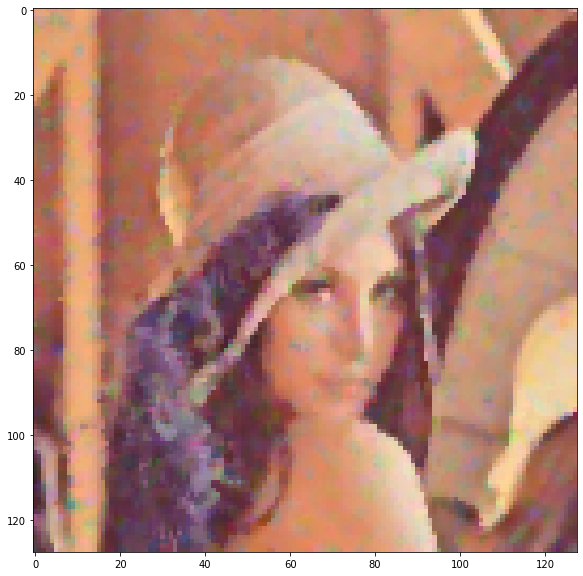

In [15]:
# Filtered Image
_ = plt.imshow(filteredG)